In [1]:
from base64 import decodebytes
from skimage.io import imread
from io import BytesIO
from skimage.color import rgba2rgb
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import *
from tensorflow.keras import Model
from tensorflow.keras.losses import CategoricalCrossentropy
import numpy as np
from gramex.data import filter as gfilter
from h5py import File
from tqdm import tqdm
from matplotlib import pyplot as plt
from chart_annotation import plot_history
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [2]:
df = gfilter('sqlite:///data/charts_coarse.db', table='charts')

In [3]:
to_keep = df['parent_label'].value_counts()[df['parent_label'].value_counts() >= 25].index
df = df[df['parent_label'].isin(to_keep)]
df.head()

,label,validated_label,image,chart_id,is_validated,parent_label
1,populationpyramid,populationpyramid,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",9,1,barchart
6,Map,map,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",14,1,map
7,dotmatrix,dotmatrix,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",15,1,dotmatrix
8,bubble chart,scatterplot,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",16,1,bubblechartlegend
10,spiral bubble,spiral-bubble,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",18,1,bubblechartlegend


In [4]:
vc = df['parent_label'].value_counts() / df.shape[0]
vc

barchart             0.330357
map                  0.193452
bubblechartlegend    0.163690
linechart            0.136905
donut                0.101190
dotmatrix            0.074405
Name: parent_label, dtype: float64

In [5]:
X = np.zeros((df.shape[0], 299, 299, 3))

In [6]:
for i, (_, row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
    imgdata = row['image'].split(',')[-1]
    bytedata = decodebytes(imgdata.encode())
    image = imread(BytesIO(bytedata))
    image = rgba2rgb(image)
    image = resize(image, (299, 299), preserve_range=True)
    X[i] = image

100%|██████████| 336/336 [00:13<00:00, 24.70it/s]


In [7]:
lenc = LabelEncoder()
y = lenc.fit_transform(df['parent_label'])

In [8]:
model = Xception(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=vc.shape[0],
    classifier_activation="softmax",
)

In [24]:
# model.trainable = False
# ip_layer = layers.Input(shape=(299, 299, 3))
# x = model(ip_layer, training=False)
# x = layers.Dense(df['parent_label'].nunique())(x)
# outer = Model(ip_layer, x)

# outer.compile(optimizer=Adam(lr=0.01),
#               loss=CategoricalCrossentropy(from_logits=True), metrics=['categorical_accuracy'])
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['categorical_accuracy'])

In [10]:
y = to_categorical(y)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, stratify=np.argmax(y, axis=1))

In [11]:
from tensorflow.keras.callbacks import TensorBoard

In [25]:
datagen = ImageDataGenerator(
    horizontal_flip=True, zoom_range=0.5)
datagen.fit(xtrain)
history = model.fit(
    datagen.flow(xtrain, ytrain, batch_size=8),
    steps_per_epoch=len(xtrain) / 8,
    epochs=1000,
    validation_data=(xtest, ytest),
    callbacks=[EarlyStopping('val_loss', min_delta=0.01, patience=30, restore_best_weights=True),
               TensorBoard('/tmp/xception-charts-logs/', write_graph=False)],
    verbose=1
)

Epoch 1/1000
32/31 [==============================] - 7s 215ms/step - loss: 0.4262 - categorical_accuracy: 0.8929 - val_loss: 1.1481 - val_categorical_accuracy: 0.7619
Epoch 2/1000
32/31 [==============================] - 6s 192ms/step - loss: 0.1892 - categorical_accuracy: 0.9325 - val_loss: 1.6017 - val_categorical_accuracy: 0.6429
Epoch 3/1000
32/31 [==============================] - 6s 191ms/step - loss: 0.2551 - categorical_accuracy: 0.9246 - val_loss: 1.3815 - val_categorical_accuracy: 0.6786
Epoch 4/1000
32/31 [==============================] - 6s 193ms/step - loss: 0.3283 - categorical_accuracy: 0.8929 - val_loss: 1.1934 - val_categorical_accuracy: 0.7143
Epoch 5/1000
32/31 [==============================] - 6s 193ms/step - loss: 0.3238 - categorical_accuracy: 0.8770 - val_loss: 1.4941 - val_categorical_accuracy: 0.7262
Epoch 6/1000
32/31 [==============================] - 6s 191ms/step - loss: 0.2103 - categorical_accuracy: 0.9127 - val_loss: 2.0091 - val_categorical_accuracy:

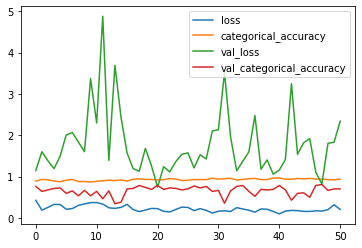

In [27]:
plot_history(history)

In [28]:
model.save('xception-blank.h5')